# MLOps. Практическое задание №5 (vo_HW)

__Цель задания__: Применить средства автоматизации тестирования python для автоматического тестирования качества работы модели машинного обучения на различных датасетах.


Реавлизация генератора датасета взято из Практического задания №1

## Этапы работы

1. Создать три датасета с «качественными данными», на которых можно обучить простую модель линейной регрессии:
    * Датасет с чистыми данными
    * Датасет с шумами
    * Датасет с шумами и выбросами
2. На одном из этих датасетов обучить модель линейной регрессии
3. Проверить работу обученной модели на разных датасетах

## Создание датасетов

### 1.1. Настройки генератора

In [1]:
# Импорт библиотек
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

In [2]:
# Константы общие
RANDOM_STATE = 100
SAMPLE_SIZE = 300_000

# Диапазон лет
YEAR_FROM = 2020
YEAR_TO = 2024

# Константы - Стаж работы
WORK_EXPERIENCE_FROM = 0
WORK_EXPERIENCE_TO = 20

# Грейды стажа
WORK_GRADES_DF = pd.DataFrame.from_dict([
    {"name": "Young Padawan", "from": 0, "to": 1, "koef": 0.6, "year_koef": 0.0},
    {"name": "Junior", "from": 1, "to": 3, "koef": 0.8, "year_koef": 0.0},
    {"name": "Middle", "from": 3, "to": 7, "koef": 1.1, "year_koef": 0.05},
    {"name": "Senior", "from": 7, "to": 12, "koef": 1.5, "year_koef": 0.08},
    {"name": "Architect", "from": 12, "to": 100, "koef": 1.9, "year_koef": 0.15},
]) 
WORK_GRADES_DF.columns=["WORK_GRADE_NAME", "WORK_GRADE_YEAR_FROM", "WORK_GRADE_YEAR_TO", "WORK_GRADE_KOEF", "WORK_GRADE_YEAR_KOEF"]

# Модель работы
WORK_MODELS_DF = pd.DataFrame.from_dict([
    {"name": "On-Site", "koef": 1.0},
    {"name": "Remote",  "koef": 0.7},
    {"name": "Hybrid",  "koef": 0.85}
])
WORK_MODELS_DF.columns=["WORK_MODEL_NAME", "WORK_MODEL_KOEF"]

# Тип занятости
EMPLOYMENT_TYPES_DF = pd.DataFrame.from_dict([
    {"name": "Full-Time", "koef": 1.0},
    {"name": "Contract", "koef": 1.2},
    {"name": "One Work", "koef": 1.2}
])
EMPLOYMENT_TYPES_DF.columns=["EMPLOYMENT_TYPE_NAME", "EMPLOYMENT_TYPE_KOEF"]

# Должности
JOB_TITLES_DF = pd.DataFrame.from_dict([
    {"name": "Data Engineer", "base": 2000.0},
    {"name": "BI Developer", "base": 1750.0},
    {"name": "Developer", "base": 1640.0},
    # {"name": "Designer", "base": 1640.0},
    # {"name": "Cleaner", "base": 600.0},
    # {"name": "Driver", "base": 800.0},
    # {"name": "Manager", "base": 2100.0},
])
JOB_TITLES_DF.columns=["JOB_TITLE_NAME", "JOB_TITLE_BASE"]

# Параметры шума по целевой переменной
SALARY_NOISE_LOW = -0.3
SALARY_NOISE_HIGH = 0.3

# Параметры шума по параметрам
WORK_EXPERIENCE_NOISE_LOW = -1
WORK_EXPERIENCE_NOISE_HIGH = 1

# Путь для сохранения данных
DATASET_PATH = "./data"

In [3]:
# Настройка рандомизатора
np.random.seed(RANDOM_STATE)

In [4]:
# Сохранение наборов
def save_dataset(df: pd.DataFrame, name: str, isTest:bool = False) -> None:
    path = os.path.join(DATASET_PATH, 'train')
    if isTest:
        path = os.path.join(DATASET_PATH, 'test')
    if not os.path.exists(path):
        os.makedirs(path)
    df.to_csv(f"{os.path.join(path, name)}.csv", index=False)

In [5]:
# Генерация распределения вероятности
def get_exp_p(cnt: int) -> list[int]:
    a = np.random.exponential(1.0, cnt)
    b = sum(a)
    c = a / b
    c[len(c) - 1] = 1 - sum(c[:len(c) - 1])
    return c

### 1.2. Получение рандомных ключей

In [6]:
# Генерация Диапазона лет
YEAR_KEYS = np.random.choice(
    range(YEAR_FROM, YEAR_TO + 1), 
    size=SAMPLE_SIZE,
    p=get_exp_p(len(range(YEAR_FROM, YEAR_TO + 1))))
YEAR_KEYS

array([2020, 2023, 2023, ..., 2020, 2020, 2023])

In [7]:
# Генерация Стажа работы
WORK_EXPERIENCE_KEYS = np.random.choice(
    range(WORK_EXPERIENCE_FROM, WORK_EXPERIENCE_TO + 1), 
    size=SAMPLE_SIZE,
    p=get_exp_p(len(range(WORK_EXPERIENCE_FROM, WORK_EXPERIENCE_TO + 1))))
WORK_EXPERIENCE_KEYS

array([ 2, 12, 12, ..., 11, 15, 18])

In [8]:
# Расчет Грейдов
WORK_GRADE_KEYS = np.zeros(
    shape=(SAMPLE_SIZE),
    dtype=int
)

for i in range(SAMPLE_SIZE):
    work_experience: int = WORK_EXPERIENCE_KEYS[ i ]
    EXP_FROM_CL = WORK_GRADES_DF["WORK_GRADE_YEAR_FROM"] <= work_experience
    EXP_TO_CL = WORK_GRADES_DF["WORK_GRADE_YEAR_TO"] >= work_experience
    RESULT_INDEX_LIST = WORK_GRADES_DF.index[EXP_FROM_CL & EXP_TO_CL]
    if len(RESULT_INDEX_LIST) > 0:
        WORK_GRADE_KEYS[ i ] = RESULT_INDEX_LIST[ 0 ]
    else:
        print(f"{work_experience}")
        WORK_GRADE_KEYS[ i ] = np.NAN

WORK_GRADE_KEYS

array([1, 3, 3, ..., 3, 4, 4])

In [9]:
# Генерация Модели работы
WORK_MODEL_KEYS = np.random.choice(
    range(0, len(WORK_MODELS_DF)), 
    size=SAMPLE_SIZE,
    p=get_exp_p(len(range(0, len(WORK_MODELS_DF)))))
WORK_MODEL_KEYS

array([2, 2, 2, ..., 2, 2, 2])

In [10]:
# Генерация Типа занятости
# EMPLOYMENT_TYPE_KEYS = np.random.randint(
#     0, 
#     len(EMPLOYMENT_TYPES_DF), 
#     size=SAMPLE_SIZE)
EMPLOYMENT_TYPE_KEYS = np.random.choice(
    range(0, len(EMPLOYMENT_TYPES_DF)), 
    size=SAMPLE_SIZE,
    p=get_exp_p(len(range(0, len(EMPLOYMENT_TYPES_DF)))))
EMPLOYMENT_TYPE_KEYS

array([0, 1, 1, ..., 1, 0, 0])

In [11]:
# Генерация Должности
JOB_TITLE_KEYS = np.random.choice(
    range(0, len(JOB_TITLES_DF)), 
    size=SAMPLE_SIZE,
    p=get_exp_p(len(range(0, len(JOB_TITLES_DF)))))
JOB_TITLE_KEYS

array([2, 2, 2, ..., 0, 2, 2])

### 1.3. Создание базового датасета

In [12]:
# Создание единого датасета
df = pd.DataFrame(
    data=np.array([JOB_TITLE_KEYS, EMPLOYMENT_TYPE_KEYS, WORK_MODEL_KEYS, WORK_GRADE_KEYS, WORK_EXPERIENCE_KEYS, YEAR_KEYS]).T,
    columns=['JOB_TITLE_KEYS', 'EMPLOYMENT_TYPE_KEYS', 'WORK_MODEL_KEYS', 'WORK_GRADE_KEYS', 'WORK_EXPERIENCE_YEARS', 'YEAR']
)
df.sample(5)

,JOB_TITLE_KEYS,EMPLOYMENT_TYPE_KEYS,WORK_MODEL_KEYS,WORK_GRADE_KEYS,WORK_EXPERIENCE_YEARS,YEAR
46506,1,0,2,2,4,2023
278775,0,1,2,2,4,2023
152138,0,1,2,0,1,2023
105437,2,0,2,2,5,2023
225945,2,0,2,2,6,2023


In [13]:
# Соединение со справочником JOB_TITLES
full_df = df.merge(JOB_TITLES_DF, left_on="JOB_TITLE_KEYS", right_index=True) \
    .merge(EMPLOYMENT_TYPES_DF, left_on="EMPLOYMENT_TYPE_KEYS", right_index=True) \
    .merge(WORK_MODELS_DF, left_on="WORK_MODEL_KEYS", right_index=True) \
    .merge(WORK_GRADES_DF, left_on="WORK_GRADE_KEYS", right_index=True) \
    .drop(columns=["JOB_TITLE_KEYS", "EMPLOYMENT_TYPE_KEYS", "WORK_MODEL_KEYS", "WORK_GRADE_KEYS"])
full_df.sample(5)

,WORK_EXPERIENCE_YEARS,YEAR,JOB_TITLE_NAME,JOB_TITLE_BASE,EMPLOYMENT_TYPE_NAME,EMPLOYMENT_TYPE_KOEF,WORK_MODEL_NAME,WORK_MODEL_KOEF,WORK_GRADE_NAME,WORK_GRADE_YEAR_FROM,WORK_GRADE_YEAR_TO,WORK_GRADE_KOEF,WORK_GRADE_YEAR_KOEF
252690,2,2020,BI Developer,1750.0,Full-Time,1.0,Hybrid,0.85,Junior,1,3,0.8,0.00
16533,1,2020,Developer,1640.0,Contract,1.2,On-Site,1.00,Young Padawan,0,1,0.6,0.00
168568,1,2023,Developer,1640.0,Full-Time,1.0,Hybrid,0.85,Young Padawan,0,1,0.6,0.00
9028,14,2020,Developer,1640.0,Contract,1.2,Hybrid,0.85,Architect,12,100,1.9,0.15
38871,9,2020,Developer,1640.0,Contract,1.2,Hybrid,0.85,Senior,7,12,1.5,0.08


In [14]:
# Расчет ЗП
def calc_salary(row) -> float:
    salary = row["JOB_TITLE_BASE"]
    salary = salary * row["EMPLOYMENT_TYPE_KOEF"]
    salary = salary * row["WORK_MODEL_KOEF"]    # Да, удаленщики получают чуть ниже офисников
    salary = salary * row["WORK_GRADE_KOEF"]
    salary = salary + (salary * row["WORK_GRADE_YEAR_KOEF"]) \
        * (row["WORK_EXPERIENCE_YEARS"] - row["WORK_GRADE_YEAR_FROM"])
    salary = salary + np.random.uniform(-100, 100, 1)[0]
    return salary

full_df['SALARY'] = full_df.apply(calc_salary, axis=1)
full_df.sample(5)['SALARY']

298963    6951.185948
284656    2289.670663
195941    2913.558043
67683     4315.935376
167977    2501.930673
Name: SALARY, dtype: float64

In [15]:
# Удаление служебных полей 
# В теории мы можем знать коэффициенты 
# расчета ЗП, но сейчас они нам не нужны
full_df.drop(['JOB_TITLE_BASE', 'EMPLOYMENT_TYPE_KOEF',
              'WORK_MODEL_KOEF', 'WORK_GRADE_YEAR_FROM',
              'WORK_GRADE_YEAR_TO', 'WORK_GRADE_KOEF',
              'WORK_GRADE_YEAR_KOEF'],
              axis=1,
              inplace=True)

In [16]:
# Вывод финального результата
full_df.sample(5)

,WORK_EXPERIENCE_YEARS,YEAR,JOB_TITLE_NAME,EMPLOYMENT_TYPE_NAME,WORK_MODEL_NAME,WORK_GRADE_NAME,SALARY
204565,4,2022,Data Engineer,Contract,Hybrid,Middle,2390.967370
108626,16,2020,Developer,Full-Time,On-Site,Architect,4963.597896
92015,1,2020,Developer,Contract,Hybrid,Young Padawan,1071.393126
256149,8,2021,Developer,One Work,Hybrid,Senior,2745.959704
265932,5,2020,Developer,Full-Time,Hybrid,Middle,1773.840940


In [17]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   WORK_EXPERIENCE_YEARS  300000 non-null  int32  
 1   YEAR                   300000 non-null  int32  
 2   JOB_TITLE_NAME         300000 non-null  object 
 3   EMPLOYMENT_TYPE_NAME   300000 non-null  object 
 4   WORK_MODEL_NAME        300000 non-null  object 
 5   WORK_GRADE_NAME        300000 non-null  object 
 6   SALARY                 300000 non-null  float64
dtypes: float64(1), int32(2), object(4)
memory usage: 13.7+ MB


### 1.4. Формирование набора 1

Данные полностью сгенерированные, без шумов и выбросов. Ожидаются высокие показатели модели, так как зависимость данных подчиняется простой формуле.

In [18]:
# Разбиение на учебную и тестовую выборки
data1_train_df, data1_test_df = train_test_split(
    full_df, 
    test_size=0.3, 
    random_state=RANDOM_STATE)

In [19]:
# Сохранение в папки
save_dataset(data1_train_df, "data1")
save_dataset(data1_test_df, "data1", isTest=True)

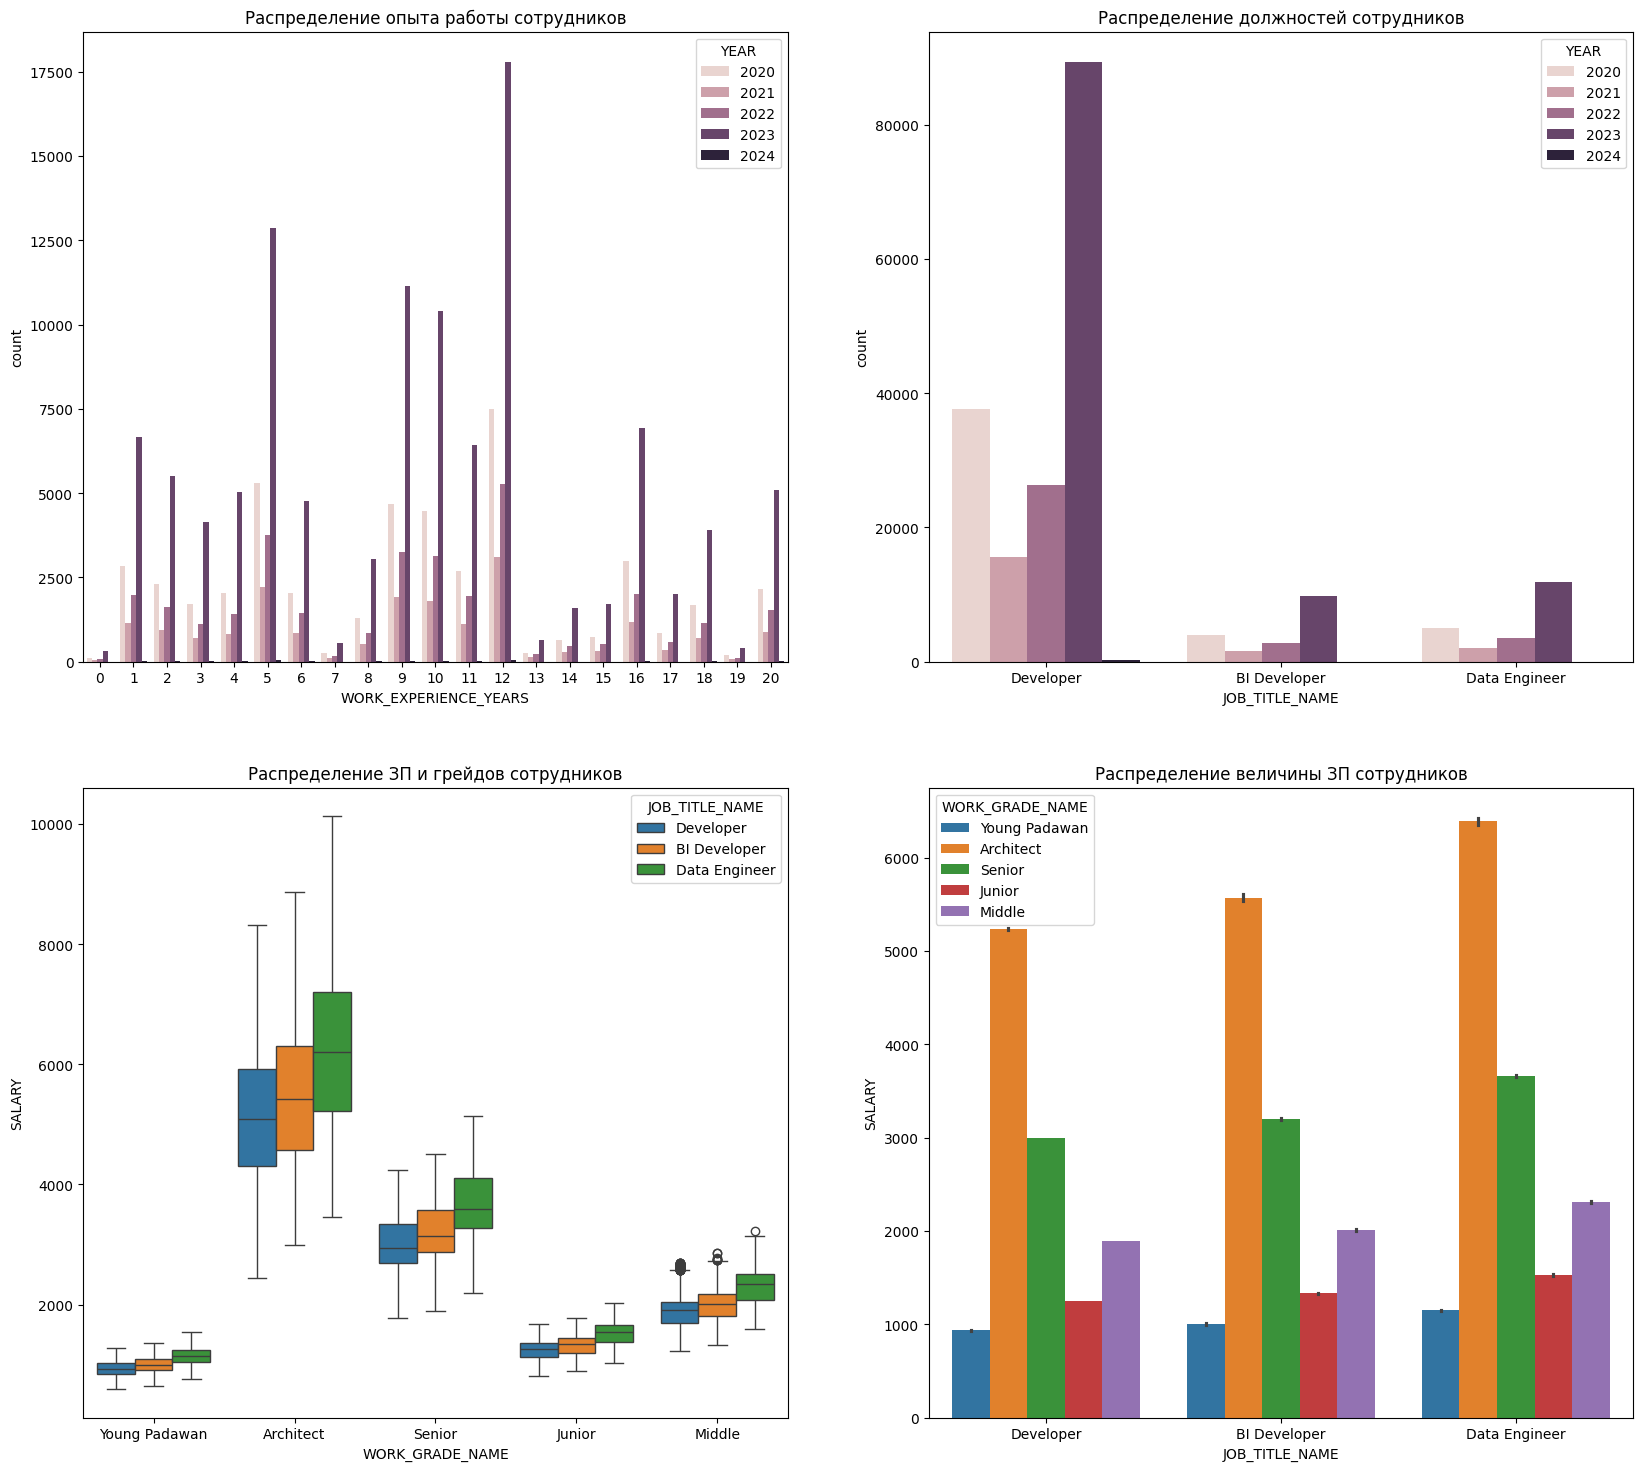

In [20]:
x_figsize: int = 20
y_figsize: int = 18
n_rows: int = 2
n_cols: int = 2


plt.subplots(
    figsize=(x_figsize, y_figsize),
    nrows=n_rows,
    ncols=n_cols);

ax = plt.subplot(n_rows, n_cols, 1);
sns.countplot(
    data1_train_df,
    x='WORK_EXPERIENCE_YEARS',
    hue='YEAR'
)
ax.title.set_text('Распределение опыта работы сотрудников')


ax = plt.subplot(n_rows, n_cols, 2);
sns.countplot(
    data1_train_df,
    x='JOB_TITLE_NAME',
    hue='YEAR'
)
ax.title.set_text('Распределение должностей сотрудников')


ax = plt.subplot(n_rows, n_cols, 3);
sns.boxplot(
    data1_train_df,
    x='WORK_GRADE_NAME',
    y='SALARY',
    hue='JOB_TITLE_NAME'
)
ax.title.set_text('Распределение ЗП и грейдов сотрудников')


ax = plt.subplot(n_rows, n_cols, 4);
sns.barplot(
    data1_train_df,
    x='JOB_TITLE_NAME',
    y='SALARY',
    hue='WORK_GRADE_NAME'
)
ax.title.set_text('Распределение величины ЗП сотрудников')

### 1.5. Формирование набора 2

Добавление шума в целевую переменную.

In [21]:
# Копирование исходного датасета
full_2_df = full_df.copy(True)

In [22]:
# Генерация шума для целевой переменной в диапазоне от 0.3 до -0.3
salary_noise_koef = np.random.uniform(
    low=SALARY_NOISE_LOW, 
    high=SALARY_NOISE_HIGH, 
    size=SAMPLE_SIZE)
salary_noise_koef

array([-0.02323766, -0.07157602, -0.02964331, ...,  0.07913996,
       -0.04877427, -0.15322266])

In [23]:
# Добавление шума в отдельный столбец
full_2_df["SALARY"] = full_2_df["SALARY"] + full_2_df["SALARY"] * salary_noise_koef

In [24]:
full_2_df.sample(5)

,WORK_EXPERIENCE_YEARS,YEAR,JOB_TITLE_NAME,EMPLOYMENT_TYPE_NAME,WORK_MODEL_NAME,WORK_GRADE_NAME,SALARY
96306,11,2022,BI Developer,Contract,Hybrid,Senior,3488.100870
69585,10,2023,Developer,One Work,Hybrid,Senior,2455.443713
46539,5,2023,Developer,Contract,Hybrid,Middle,2598.442694
151064,9,2023,Developer,Full-Time,On-Site,Senior,2279.123378
123888,16,2020,Developer,Contract,Hybrid,Architect,5265.477147


In [25]:
# Разбиение на учебную и тестовую выборки
data2_train_df, data2_test_df = train_test_split(
    full_2_df, 
    test_size=0.3, 
    random_state=RANDOM_STATE)

In [26]:
# Сохранение в папки
save_dataset(data2_train_df, "data2")
save_dataset(data2_test_df, "data2", isTest=True)

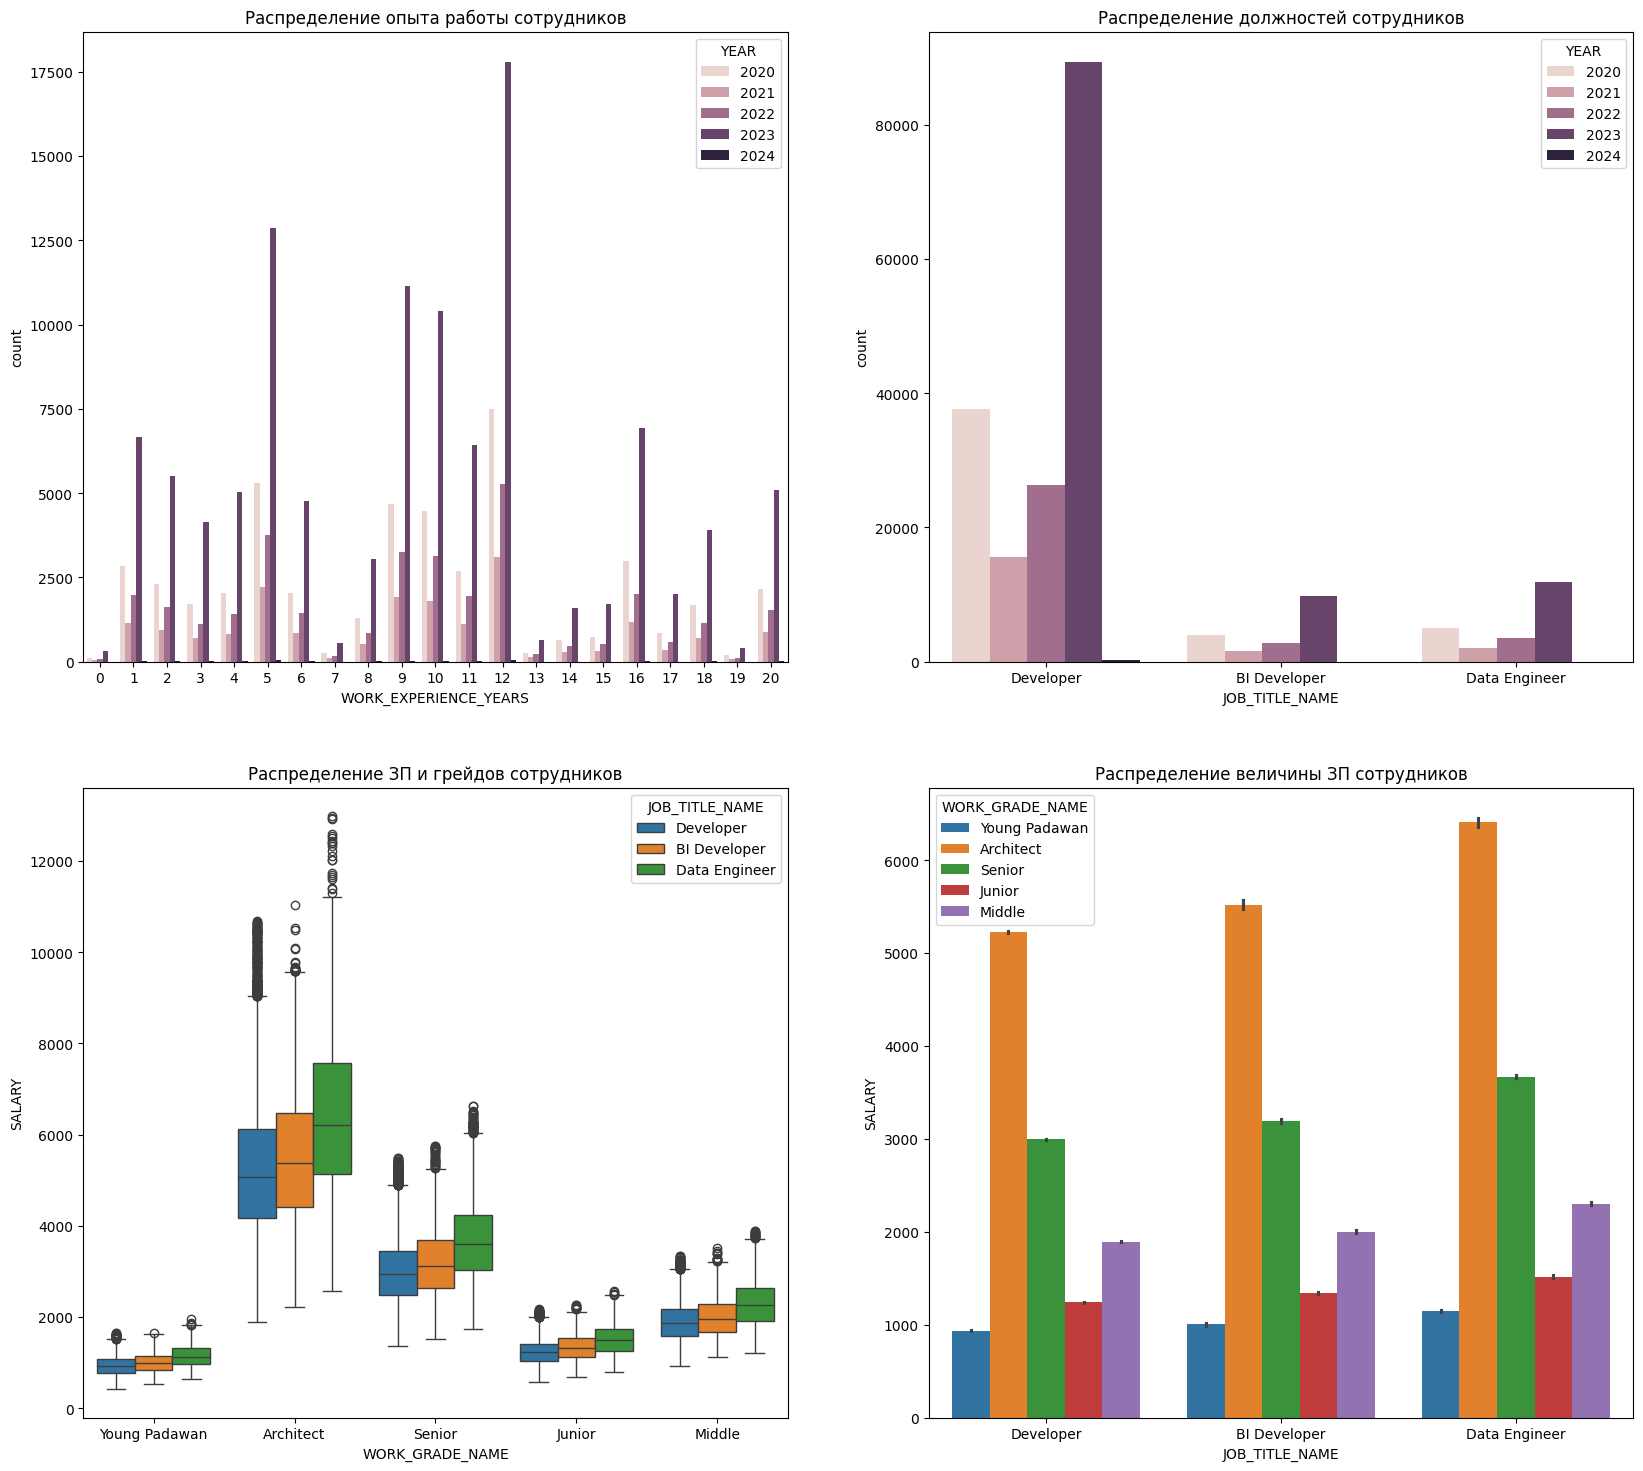

In [27]:
x_figsize: int = 20
y_figsize: int = 18
n_rows: int = 2
n_cols: int = 2


plt.subplots(
    figsize=(x_figsize, y_figsize),
    nrows=n_rows,
    ncols=n_cols);

ax = plt.subplot(n_rows, n_cols, 1);
sns.countplot(
    data2_train_df,
    x='WORK_EXPERIENCE_YEARS',
    hue='YEAR'
)
ax.title.set_text('Распределение опыта работы сотрудников')


ax = plt.subplot(n_rows, n_cols, 2);
sns.countplot(
    data2_train_df,
    x='JOB_TITLE_NAME',
    hue='YEAR'
)
ax.title.set_text('Распределение должностей сотрудников')


ax = plt.subplot(n_rows, n_cols, 3);
sns.boxplot(
    data2_train_df,
    x='WORK_GRADE_NAME',
    y='SALARY',
    hue='JOB_TITLE_NAME'
)
ax.title.set_text('Распределение ЗП и грейдов сотрудников')


ax = plt.subplot(n_rows, n_cols, 4);
sns.barplot(
    data2_train_df,
    x='JOB_TITLE_NAME',
    y='SALARY',
    hue='WORK_GRADE_NAME'
)
ax.title.set_text('Распределение величины ЗП сотрудников')

На графике Распределения ЗП и грейдов видно, что добавились выбросы

### 1.6. Формирование набора 3

Добавление шума к стажу работы и выбросов в целевую переменную.

In [28]:
# Копирование исходного датасета
full_3_df = full_df.copy(True)

In [29]:
# Генерация шума для стажа работы (кто то приверает на 1 или 2 года)
work_experience_noise_koef = np.random.choice([0, 1, 2], SAMPLE_SIZE, p=[0.9, 0.08, 0.02])
work_experience_noise_koef

array([0, 0, 0, ..., 0, 0, 0])

In [30]:
print(f"Результат распределения: {dict(zip(*np.unique(work_experience_noise_koef, return_counts=True)))}")

Результат распределения: {0: 269889, 1: 24029, 2: 6082}


In [31]:
# Добавление шума в отдельный столбец
full_3_df["WORK_EXPERIENCE_YEARS"] = full_3_df["WORK_EXPERIENCE_YEARS"] + work_experience_noise_koef
full_3_df.sample(5)

,WORK_EXPERIENCE_YEARS,YEAR,JOB_TITLE_NAME,EMPLOYMENT_TYPE_NAME,WORK_MODEL_NAME,WORK_GRADE_NAME,SALARY
185781,9,2023,Developer,Contract,Hybrid,Senior,2837.179104
65071,2,2023,Developer,Contract,Hybrid,Junior,1242.353964
25307,18,2023,Developer,Full-Time,Hybrid,Architect,5031.486430
256080,5,2023,BI Developer,Full-Time,Hybrid,Middle,1836.294434
85956,10,2023,Data Engineer,Full-Time,Hybrid,Senior,3170.205448


In [32]:
# Генерация выбросов по ЗП (выбросы почти в разы)
outliers_koef = np.random.choice([-2.5, -2, 0, 2, 3], SAMPLE_SIZE, p=[0.01, 0.04, 0.9, 0.04, 0.01])
print(f"Результат распределения: {dict(zip(*np.unique(outliers_koef, return_counts=True)))}")

Результат распределения: {-2.5: 3074, -2.0: 12072, 0.0: 269764, 2.0: 12126, 3.0: 2964}


In [33]:
# Применение выбросов на данные
full_3_df["SALARY"] = full_3_df["SALARY"] + full_3_df["SALARY"] * outliers_koef / 10
full_3_df.sample(5)

,WORK_EXPERIENCE_YEARS,YEAR,JOB_TITLE_NAME,EMPLOYMENT_TYPE_NAME,WORK_MODEL_NAME,WORK_GRADE_NAME,SALARY
237503,5,2021,Developer,Full-Time,Hybrid,Middle,1520.948561
177436,12,2023,Developer,Full-Time,Hybrid,Senior,2149.864881
82445,8,2023,Data Engineer,Full-Time,Hybrid,Senior,3624.259096
19198,11,2020,BI Developer,Full-Time,On-Site,Senior,3396.112632
296025,3,2023,Developer,Contract,Hybrid,Junior,1339.342690


In [34]:
# Разбиение на учебную и тестовую выборки
data3_train_df, data3_test_df = train_test_split(
    full_3_df, 
    test_size=0.3, 
    random_state=RANDOM_STATE)

In [35]:
# Сохранение в папки
save_dataset(data3_train_df, "data3")
save_dataset(data3_test_df, "data3", isTest=True)

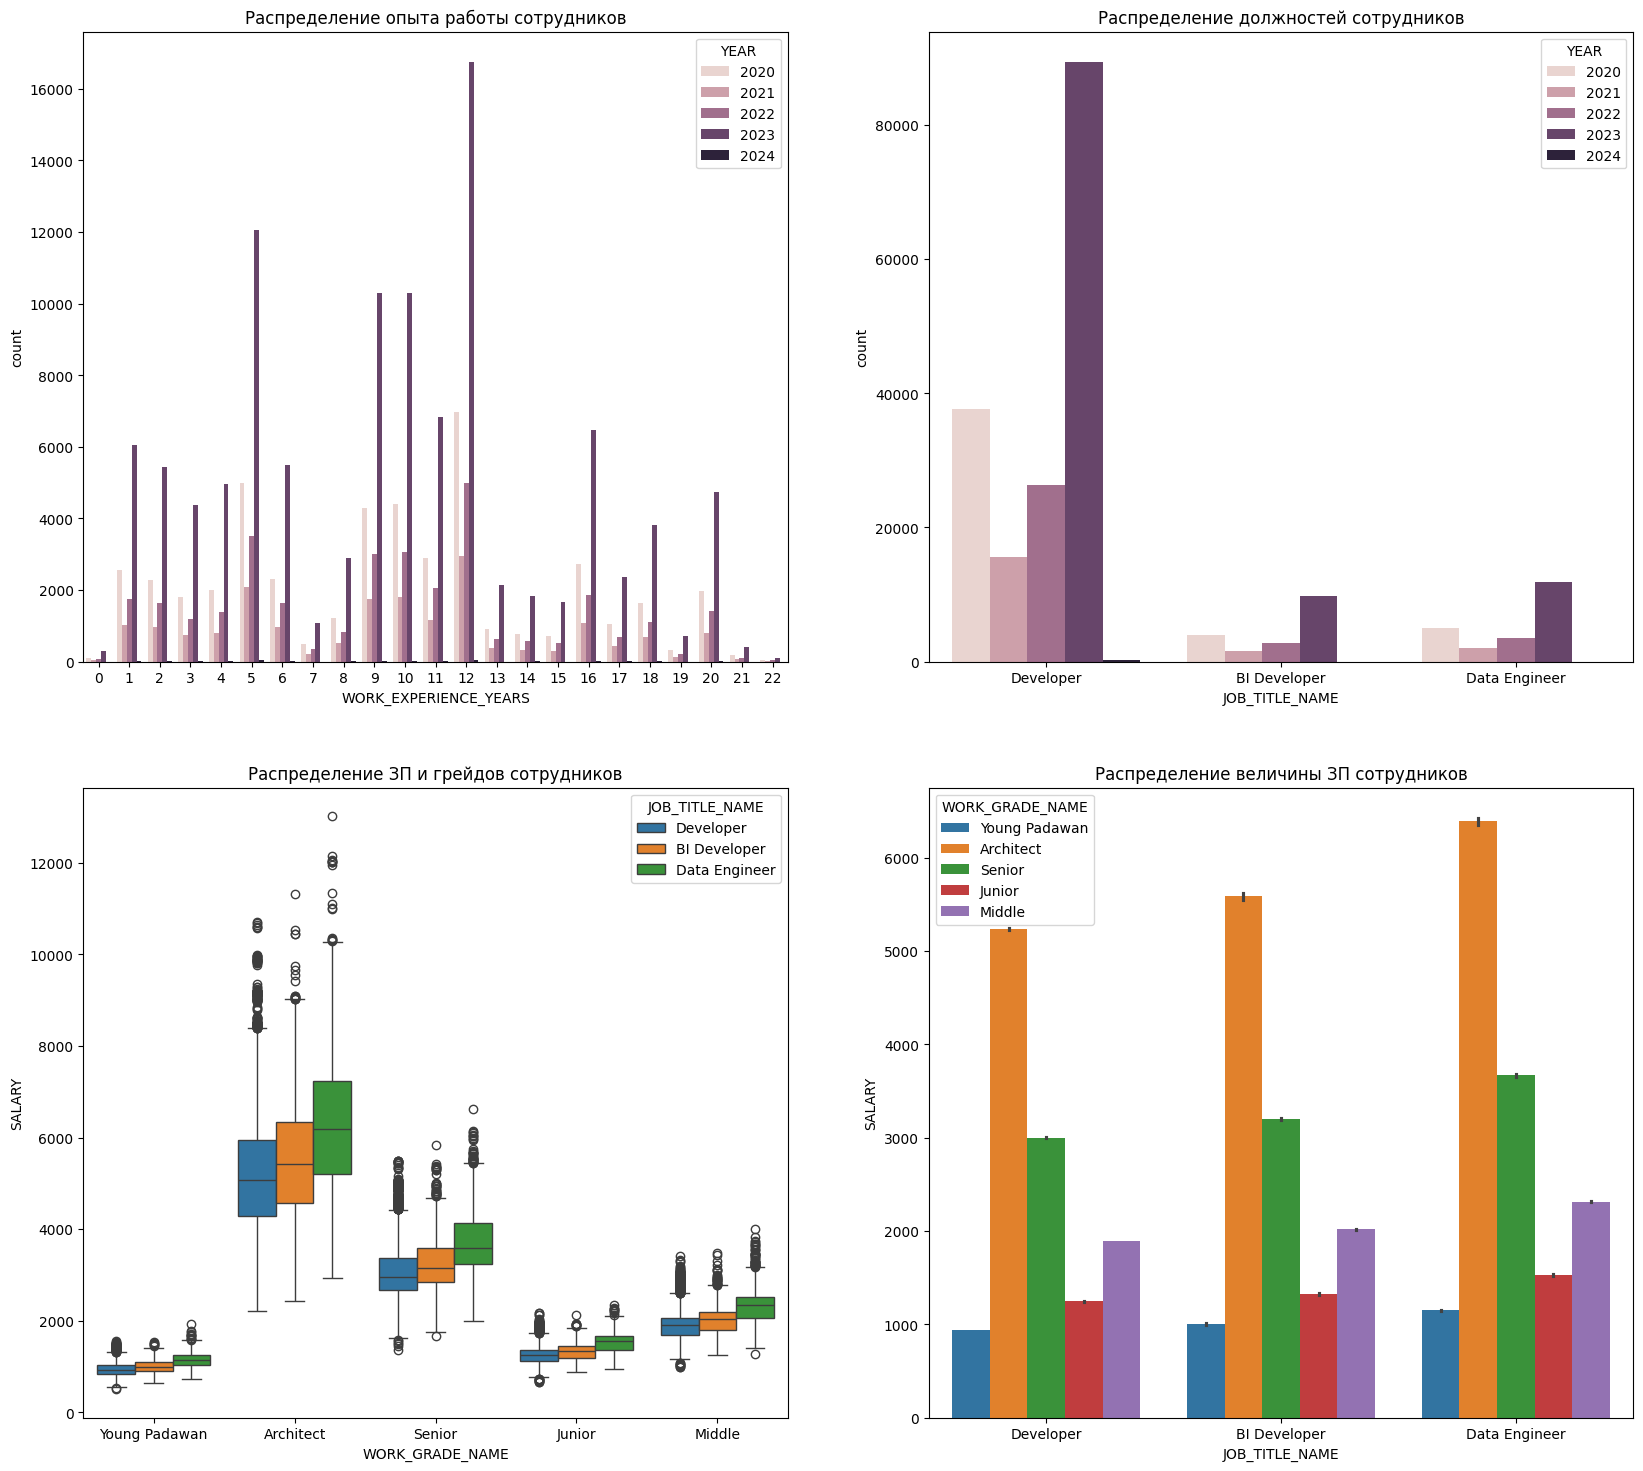

In [36]:
x_figsize: int = 20
y_figsize: int = 18
n_rows: int = 2
n_cols: int = 2


plt.subplots(
    figsize=(x_figsize, y_figsize),
    nrows=n_rows,
    ncols=n_cols);

ax = plt.subplot(n_rows, n_cols, 1);
sns.countplot(
    data3_train_df,
    x='WORK_EXPERIENCE_YEARS',
    hue='YEAR'
)
ax.title.set_text('Распределение опыта работы сотрудников')


ax = plt.subplot(n_rows, n_cols, 2);
sns.countplot(
    data3_train_df,
    x='JOB_TITLE_NAME',
    hue='YEAR'
)
ax.title.set_text('Распределение должностей сотрудников')


ax = plt.subplot(n_rows, n_cols, 3);
sns.boxplot(
    data3_train_df,
    x='WORK_GRADE_NAME',
    y='SALARY',
    hue='JOB_TITLE_NAME'
)
ax.title.set_text('Распределение ЗП и грейдов сотрудников')


ax = plt.subplot(n_rows, n_cols, 4);
sns.barplot(
    data3_train_df,
    x='JOB_TITLE_NAME',
    y='SALARY',
    hue='WORK_GRADE_NAME'
)
ax.title.set_text('Распределение величины ЗП сотрудников')

На графике Распределения ЗП и грейдов видно, что добавились выбросы

## Обучение модели

In [37]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

from sklearn.linear_model import LinearRegression

from joblib import dump, load

### Предобработка данных

In [38]:
# Определим, как будем обрабатывать параметры
ordinal_cols: list = ['JOB_TITLE_NAME', 'EMPLOYMENT_TYPE_NAME', 'WORK_MODEL_NAME', 'WORK_GRADE_NAME']
stand_scaler_cols: list = ['WORK_EXPERIENCE_YEARS', 'YEAR']

# Создание pipeline для Ordinal кодирования
pipe_ordinal = Pipeline([
    ('encoder', OrdinalEncoder())
])
# Создание pipeline для стандартизации
pipe_stand = Pipeline([
    ('scaler', StandardScaler())
])

# Создание трансформера колонок данных (далее в этом контексте "трансформер")
preprocessors = ColumnTransformer(transformers=[
    ('stand_cols', pipe_stand, stand_scaler_cols),
    ('ordinal_cols', pipe_ordinal, ordinal_cols)
])

# Обучение трансформера
preprocessors.fit(full_df.drop('SALARY', axis=1))

# Соберем имена колонок данных после трансформаций
trans_cols_list = []
trans_cols_list.extend(stand_scaler_cols)
trans_cols_list.extend(ordinal_cols)

# Сохранение трансформера
if not os.path.exists('./model/'):
    os.makedirs('./model/')
dump(preprocessors, f'./model/trans.joblib')

preprocessors

ColumnTransformer(transformers=[('stand_cols',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['WORK_EXPERIENCE_YEARS', 'YEAR']),
                                ('ordinal_cols',
                                 Pipeline(steps=[('encoder',
                                                  OrdinalEncoder())]),
                                 ['JOB_TITLE_NAME', 'EMPLOYMENT_TYPE_NAME',
                                  'WORK_MODEL_NAME', 'WORK_GRADE_NAME'])])

In [39]:
# Предобработка всех данных
X_data1_train = preprocessors.transform(data1_train_df.drop('SALARY', axis=1))
y_data1_train = data1_train_df['SALARY']

# X_data1_test = preprocessors.transform(data1_test_df.drop('SALARY', axis=1))
# y_data1_test = data1_test_df['SALARY']


# X_data2_train = preprocessors.transform(data2_train_df.drop('SALARY', axis=1))
# y_data2_train = data1_train_df['SALARY']

# X_data2_test = preprocessors.transform(data2_test_df.drop('SALARY', axis=1))
# y_data2_test = data2_test_df['SALARY']


# X_data3_train = preprocessors.transform(data3_train_df.drop('SALARY', axis=1))
# y_data3_train = data1_train_df['SALARY']

# X_data3_test = preprocessors.transform(data3_test_df.drop('SALARY', axis=1))
# y_data3_test = data3_test_df['SALARY']

### Обучение модели

In [40]:
# Создание модели логистической регрессии
model_data1 = LinearRegression()

# Обучение модели на данных из набора 1
model_data1.fit(X_data1_train, y_data1_train)

LinearRegression()

In [41]:
# Сохранение модели
if not os.path.exists('./model/'):
    os.makedirs('./model/')
dump(model_data1, f'./model/model.joblib')

['./model/model.joblib']

## Тестирование модели

In [42]:
import ipytest

from sklearn.metrics import r2_score

In [43]:
ipytest.autoconfig()

In [44]:
# Чтение трансформации и модели
def read_trans_and_model() -> tuple[ColumnTransformer, LinearRegression]:
    
    # Поиск и загрузка трансформации
    trans = load(f'./model/trans.joblib')
    if trans is None:
        # Это проблема, серьезная проблема
        raise RuntimeError(f"Не найдена трансформация ./model/trans.joblib")
    
    # Поиск и загрузка подходящей модели
    model = load(f'./model/model.joblib')
    if model is None:
        # Это проблема, серьезная проблема
        raise RuntimeError(f"Не найдена модель ./model/model.joblib")
    
    return trans, model

In [45]:
# Чтение данных
def read_data(data_name: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    train_path = './data/train/'
    test_path = './data/test/'
    train_file_list = [name for name in os.listdir(train_path) \
                       if name.endswith(".csv") and data_name in name]
    test_file_list = [name for name in os.listdir(test_path) \
                      if name.endswith(".csv") and data_name in name]
    if not train_file_list or not test_file_list:
        raise RuntimeError("Данные не найдены")
    
    train_df = pd.read_csv(os.path.join(train_path, train_file_list[0]))
    test_df = pd.read_csv(os.path.join(test_path, test_file_list[0]))
    return train_df, test_df

In [46]:
# Универсальный тестовый метод
def any_test_data(data_name: str, train_r2: float, test_r2: float):
    trans, model = read_trans_and_model()
    train_df, test_df = read_data(data_name)
    
    assert trans is not None, 'Трансформация не прочитана'
    assert model is not None, 'Модель не прочитана'
    assert len(train_df) > 0, 'Тренировочные данные не прочиатны'
    assert len(test_df) > 0, 'Тестовые данные не прочитаны'

    X_train = trans.transform(train_df.drop('SALARY', axis=1))
    y_train = train_df['SALARY']

    X_test = trans.transform(test_df.drop('SALARY', axis=1))
    y_test = test_df['SALARY']

    y_train_predict = model.predict(X_train)
    y_test_predict = model.predict(X_test)

    assert r2_score(y_train, y_train_predict) > train_r2, 'Низкое значение метрики на тренировачных данных'
    assert r2_score(y_test, y_test_predict) > test_r2, 'Низкое значение метрики на тестовых данных'

In [47]:
# Тест первого набора
def test_data1():
    any_test_data('data1', 0.9, 0.9)

In [48]:
# Тест второго набора
def test_data2():
    any_test_data('data2', 0.85, 0.85)

In [49]:
# Тест третьего набора
def test_data3():
    any_test_data('data3', 0.8, 0.8)

In [50]:
ipytest.run()

.F.                                                                                          [100%]
============================================ FAILURES =============================================
___________________________________________ test_data2 ____________________________________________

    def test_data2():
>       any_test_data('data2', 0.85, 0.85)

C:\Users\Aleksandr\AppData\Local\Temp\ipykernel_12344\3861618661.py:3: 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

data_name = 'data2', train_r2 = 0.85, test_r2 = 0.85

    def any_test_data(data_name: str, train_r2: float, test_r2: float):
        trans, model = read_trans_and_model()
        train_df, test_df = read_data(data_name)
    
        assert trans is not None, 'Трансформация не прочитана'
        assert model is not None, 'Модель не прочитана'
        assert len(train_df) > 0, 'Тренировочные данные не прочиатны'
        assert len(test_df) > 0, 'Тестовые да

<ExitCode.TESTS_FAILED: 1>